In [167]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
from numpy import zeros,zeros_like,array
from mpl_toolkits.axes_grid1 import ImageGrid

parameters = {'axes.titlesize': 10}
plt.rcParams.update(parameters)

In [225]:
def myForegroundMask(input_file,cmap="gray",offset=2):
    name = input_file.split(".")[2]
    input_image = cv2.imread(input_file,0)
    new_image = np.zeros_like(input_image)
    
    print(np.max(input_image))
    
    r,c = input_image.shape[:2]
    
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            if input_image[i][j] < np.mean(input_image)+offset:
                new_image[i][j]=0
            else:
                new_image[i][j]=1
    
    masked_image = new_image*input_image
        
    fig,axes = plt.subplots(1,3, constrained_layout=True)
    axes[0].imshow(input_image,cmap="gray")
    axes[0].axis("on")
    axes[0].set_title("Original Image")
    
    axes[1].imshow(new_image,cmap="gray")
    axes[1].axis("on")
    axes[1].set_title("Foreground Mask(th = 2)")
    
    im = axes[2].imshow(masked_image*2,cmap="gray")
    axes[2].axis("on")
    axes[2].set_title("Masked Image")
    
    
    fig.colorbar(im,ax=axes.ravel().tolist(),shrink=0.45)    
    plt.savefig(".."+name+"ForegroundMask.png",cmap=cmap,bbox_inches="tight",pad=-1)
    
    cv2.imwrite(".." + name+"Mask.png",new_image)
    cv2.imwrite(".." + name+"ForegroundMasked.png",masked_image*2)

128


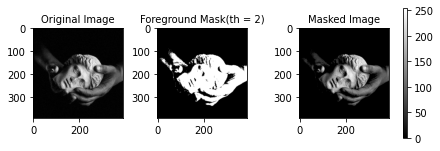

In [226]:
input_file = "../data/statue.png"
myForegroundMask(input_file)

In [212]:
def truncate(array):
    r,c = array.shape
    for i in range(r):
        for j in range(c):
            if array[i][j]<0.0:
                array[i][j] = 0
            elif array[i][j]>1.0:
                array[i][j]=1.0
    return array
        

def myLinearContrastStretching(input_file,tune=0.375,cmap="gray"):
    name = input_file.split(".")[2]
    input_image = mpimg.imread(input_file,format="png")
    #input_image = cv2.imread(input_file)
    d = 1
    if len(input_image.shape)>2:
        r,c,d = input_image.shape
    else:
        r,c = input_image.shape
    
    if d==1:
        tune = tune
        minimum,maximum = 0,255
        new_image=np.zeros_like(input_image)
        for i in range (input_image.shape[0]):
            for j in range(input_image.shape[1]):
                input_pixel = input_image[i][j]
                x= (input_pixel - minimum -tune)/(maximum-minimum)
                new_image[i][j]=x*255
        new_image = truncate(new_image)
        
    else:
        #input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)
        minimum,maximum = 0,255
        
        f = 1.016*(1+tune)/(1.016-tune)
        new_image=np.zeros_like(input_image)
        for k in range(d):
            new_image[:,:,k] = truncate((f*(input_image[:,:,k] - 0.5) + 0.5))

    fig,axes = plt.subplots(1,2, constrained_layout=True)
    axes[0].imshow(input_image,cmap="gray")
    axes[0].axis("on")
    axes[0].set_title(r"Original Image")
    im = axes[1].imshow(new_image,cmap="gray")
    axes[1].axis("on")
    axes[1].set_title(r"Linear Contrast Stretched Image")
    
    cbar = fig.colorbar(im,ax=axes.ravel().tolist(),shrink=0.45)
    plt.savefig(".."+name+"LCS.png",bbox_inches="tight",pad=-1)
    
    plt.imsave(".." + name+"LinearContrastStretching.png",new_image,cmap=cmap)

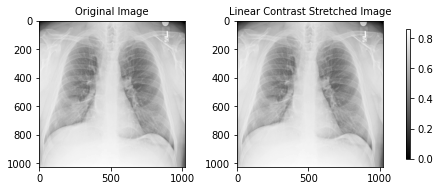

In [213]:
input_file = "../data/chestXray.png"
myLinearContrastStretching(input_file,tune=0.025)

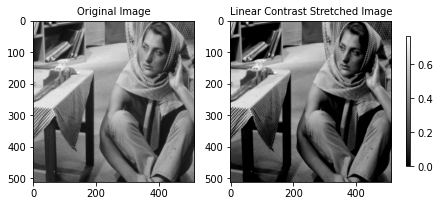

In [214]:
input_file = "../data/barbara.png"
myLinearContrastStretching(input_file,tune=0.20)

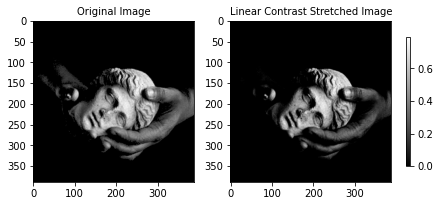

In [215]:
input_file = "../data/statueForegroundMasked.png"
myLinearContrastStretching(input_file,tune=0.20)

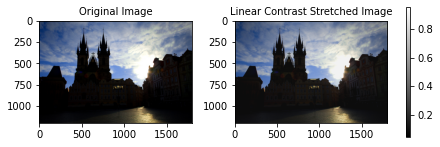

In [216]:
input_file = "../data/church.png"
myLinearContrastStretching(input_file,tune=-0.05)

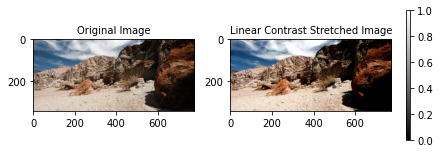

In [217]:
input_file = "../data/canyon.png"
myLinearContrastStretching(input_file,tune=0.10)

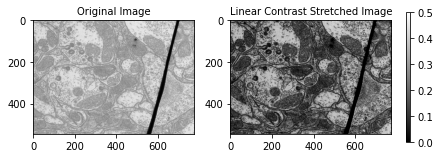

In [218]:
input_file = "../data/TEM.png"
myLinearContrastStretching(input_file,tune=0.5)

In [223]:
import cv2

def truncateHE(array):
    """
    This function truncates the array values to check whether the values
    are within range of [0,255]
    """
    if array<0:
        array = 0
    elif array>255.0:
        array = 255.0
    return array

def calculate_CDF(array,maximum,r,c):
    """
    This function is used to calculate the CDF of the 2D image.
    array : For gray scale the whole image is the input and for RGB each of the color slices are the inputs.
    maximum : maximum pixel intensity of the 2D image
    output : the CDF of the 2D image
    """
    freqs = np.zeros((maximum+1,1))
    probf = np.zeros((maximum+1,1))
    cum = np.zeros((maximum+1,1))

    for i in range(r):
        for j in range(c):
            freqs[int(array[i][j])]+=1

    for i,j in enumerate(freqs):
        probf[i] = freqs[i]/(r*c)

    for i,j in enumerate(probf):
        for k in range(i):
            cum[i] += probf[k]
    return cum

def myHE(input_file,cmap="gray"):
    """
    This is the Histogram Equalization Function.
    input : the input image
    output : None
    Saves Histogram Equalized image
    """
    
    ## SETTING FONT-SIZE FOR PLOTTING
    parameters = {'axes.titlesize': 10}
    plt.rcParams.update(parameters)
    
    name = input_file.split(".")[2]
    input_image = cv2.imread(input_file)
    
    new_image = np.zeros_like(input_image)
    
    d = 1
    if len(input_image.shape)>2:
        r,c,d = input_image.shape
    else:
        r,c = input_image.shape
    
    if d==1:
        new_input = input_image
        maximum = int(np.max(new_input))
        cum = calculate_CDF(new_input,maximum,r,c)
        
        for i in range(r):
            for j in range(c):
                new_image[i,j] = truncateHE(cum[int(new_input[i][j])]*maximum)
                
    else:
        input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)
        image_lab = cv2.cvtColor(input_image,cv2.COLOR_RGB2LAB)
        output_image = zeros_like(image_lab)
        l,a,b = cv2.split(image_lab)
        l_copy = l.copy()
        maximum = int(np.max(l))
        cum = calculate_CDF(l,maximum,r,c)
        for i in range(r):
            for j in range(c):
                l_copy[i,j] = truncateHE(cum[int(l[i,j])]*maximum)
                
        output_image[:,:,0] = l_copy
        output_image[:,:,1] = a
        output_image[:,:,2] = b
        
        output_image = cv2.cvtColor(output_image,cv2.COLOR_LAB2RGB)
        
        
    fig,axes = plt.subplots(1,2, constrained_layout=True)
    

    axes[0].imshow(input_image,cmap=cmap)
    axes[0].axis("on")
    axes[0].set_title("Original Image")  
    
    im = axes[1].imshow(output_image, cmap=cmap)
    axes[1].axis("on")
    axes[1].set_title("Histogram Equalized")
    
    cbar = fig.colorbar(im,ax=axes.ravel().tolist(),shrink=0.35)

    plt.savefig(".."+name+"HistEq.png",bbox_inches="tight",pad=-1)
    
    if d==3:
        plt.imsave(".." + name+"HE.png",output_image)
    else:
        plt.imsave(".." + name+"HE.png",output_image,cmap=cmap)

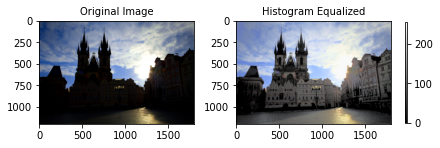

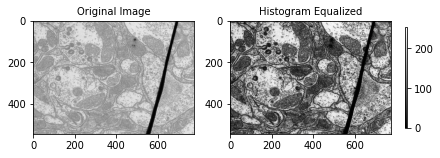

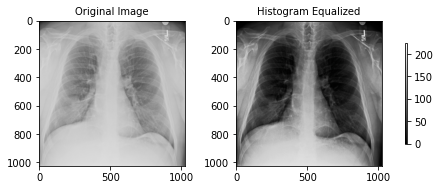

In [148]:
input_file = "../data/church.png"
myHE(input_file)
input_file = "../data/TEM.png"
myHE(input_file)
input_file = "../data/chestXray.png"
myHE(input_file)

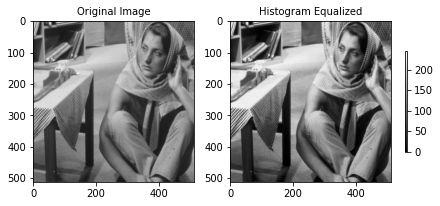

In [147]:
input_file = "../data/barbara.png"
myHE(input_file)

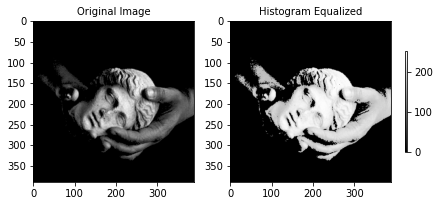

In [224]:
input_file = "../data/statueForegroundMasked.png"
myHE(input_file)

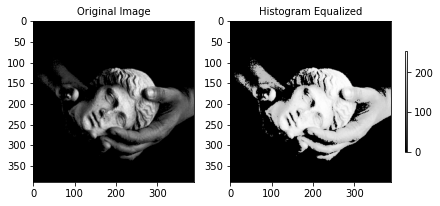

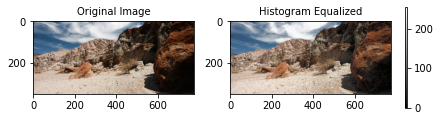

In [149]:
input_file = "../data/canyon.png"
myHE(input_file)

In [ ]:
from math import floor

def calculate_CDF(array,maximum,r,c):
    """
    This function is used to calculate the CDF of the 2D image.
    array : For gray scale the whole image is the input and for RGB each of the color slices are the inputs.
    maximum : maximum pixel intensity of the 2D image
    output : the CDF of the 2D image
    """
    freqs = np.zeros((maximum+1,1))
    probf = np.zeros((maximum+1,1))
    cum = np.zeros((maximum+1,1))

    for i in range(r):
        for j in range(c):
            freqs[int(array[i][j])]+=1

    for i,j in enumerate(freqs):
        probf[i] = freqs[i]/(r*c)

    for i,j in enumerate(probf):
        for k in range(i):
            cum[i] += probf[k]
    return cum

In [227]:
from math import floor

def calculate_CDF(array,maximum,r,c):
    """
    This function is used to calculate the CDF of the 2D image.
    array : For gray scale the whole image is the input and for RGB each of the color slices are the inputs.
    maximum : maximum pixel intensity of the 2D image
    output : the CDF of the 2D image
    """
    freqs = np.zeros((maximum+1,1))
    probf = np.zeros((maximum+1,1))
    cum = np.zeros((maximum+1,1))

    for i in range(r):
        for j in range(c):
            freqs[int(array[i][j])]+=1

    for i,j in enumerate(freqs):
        probf[i] = freqs[i]/(r*c)

    for i,j in enumerate(probf):
        for k in range(i):
            cum[i] += probf[k]
    return cum

def myHM(reference,target):
    name = target.split(".")[2]
    original_ref_image = mpimg.imread(reference,format="png")
    original_target_image = mpimg.imread(target,format="png")
    ref_image = original_ref_image.copy()
    target_image = original_target_image.copy()
    
    for l in range(3):
        r1,c1 = original_ref_image.shape[:2]
        r2,c2 = original_target_image.shape[:2]
        ref_image[:,:,l] = original_ref_image[:,:,l]*255
        target_image[:,:,l] = original_target_image[:,:,l]*255
        
        
        cum_ref = calculate_CDF(ref_image[:,:,l],int(np.max(ref_image[:,:,l])),r1,c1)
        cum_target = calculate_CDF(target_image[:,:,l],int(np.max(target_image[:,:,l])),r2,c2)
                
        transform_ref=[0 for i in range(256)]
        transform_tar=[0 for i in range(256)]
        
        for i in range(len(cum_target)):
            transform_tar[i] = floor(255 * cum_target[i])
            transform_ref[i] = floor(255 * cum_ref[i]) 
        
        transform ={}  
        
        for i in transform_tar:
            value=min(transform_ref, key=lambda x:abs(x-i))
            indx = transform_ref.index(value)
            original = transform_tar.index(i)
            transform[original]=indx
            #target_imag[i][j]=original -> target_img[i][j]=indx
        #print(transform)
        for i in range(target_image.shape[0]):
            for j in range(target_image.shape[1]):
                 if(target_image[i,j,l] in transform):
                    target_image[i,j,l]=transform[target_image[i,j,l]]
    
    
#     fig,axes = plt.subplots(1,3, constrained_layout=True, gridspec_kw={'width_ratios':[1,1,1]})

#     axes[0].imshow(ref_image/255.0)
#     axes[0].axis("on")
#     axes[1].imshow(original_target_image)
#     axes[1].axis("on")
#     #axes[0].title('Target Image')
#     #axes[1].title('Reference Image')
#     axes[2].imshow(target_image/255.0)
#     axes[2].axis("on")
#     #axes[0].title('Target Image')
#     plt.show()
    #plt.imshow(target_image/255.0)
    #plt.savefig('../data/hist_matched.png',bbox)
    
    plt.imsave(".." + name+"HM",target_image,cmap=cmap)

In [143]:
def myHM(reference,target):
    name = target.split(".")[2]
    #original_ref_image = mpimg.imread(reference,format="png")
    original_ref_image = cv2.imread(reference)
    original_ref_image = cv2.cvtColor(original_ref_image,cv2.COLOR_BGR2RGB)
    #original_target_image = mpimg.imread(target,format="png")
    original_target_image = cv2.imread(target)
    original_target_image = cv2.cvtColor(original_target_image,cv2.COLOR_BGR2RGB)
    
    ref_image = original_ref_image.copy()
    target_image = original_target_image.copy()
    
    lab_image_ref = cv2.cvtColor(ref_image, cv2.COLOR_RGB2LAB)
    l_channel_ref,a_channel_ref,b_channel_ref = cv2.split(lab_image_ref)
    
    lab_image_target = cv2.cvtColor(target_image, cv2.COLOR_RGB2LAB)
    l_channel_target,a_channel_target,b_channel_target = cv2.split(lab_image_target)
    
    r1,c1 = original_ref_image.shape[:2]
    r2,c2 = original_target_image.shape[:2]
    
    ref_image = l_channel_ref.copy()
    target_image = l_channel_target.copy()
    
    cum_ref = calculate_CDF(ref_image,int(np.max(ref_image)),r1,c1)
    cum_target = calculate_CDF(target_image,int(np.max(target_image)),r2,c2)
                
    transform_ref=[0 for i in range(256)]
    transform_tar=[0 for i in range(256)]
    
    for i in range(len(cum_target)):
        transform_tar[i] = floor(255 * cum_target[i])
        transform_ref[i] = floor(255 * cum_ref[i]) 

    transform ={}
    
#     for l in range(3):
#         r1,c1 = original_ref_image.shape[:2]
#         r2,c2 = original_target_image.shape[:2]
#         ref_image[:,:,l] = original_ref_image[:,:,l]
#         target_image[:,:,l] = original_target_image[:,:,l]
        
        
#         cum_ref = calculate_CDF(ref_image[:,:,l],int(np.max(ref_image[:,:,l])),r1,c1)
#         cum_target = calculate_CDF(target_image[:,:,l],int(np.max(target_image[:,:,l])),r2,c2)
                
#         transform_ref=[0 for i in range(256)]
#         transform_tar=[0 for i in range(256)]
        
#         for i in range(len(cum_target)):
#             transform_tar[i] = floor(255 * cum_target[i])
#             transform_ref[i] = floor(255 * cum_ref[i]) 
        
#         transform ={}  
        
    for i in transform_tar:
        value=min(transform_ref, key=lambda x:abs(x-i))
        indx = transform_ref.index(value)
        original = transform_tar.index(i)
        transform[original]=indx

        
    for i in range(target_image.shape[0]):
        for j in range(target_image.shape[1]):
             if(lab_image_target[i,j,0] in transform):
                lab_image_target[i,j,0]=transform[target_image[i,j]]
                
    lab_image_target = cv2.cvtColor(lab_image_target, cv2.COLOR_LAB2RGB)
                
    
    
    
    fig,axes = plt.subplots(1,3, constrained_layout=True)

    axes[0].imshow(original_ref_image)
    axes[0].axis("on")
    axes[0].set_title("Reference Image")
    
    axes[1].imshow(original_target_image)
    axes[1].axis("on")
    axes[1].set_title("Target Image")

    axes[2].imshow(lab_image_target)
    axes[2].axis("on")
    axes[2].set_title('Histogram Matched')
    plt.show()

    #plt.imshow(lab_image_target)
    #plt.savefig('..'+name+'HM.png',bbox_inches="tight")
    
    plt.imsave(".." + name+"HM.png",lab_image_target,cmap=cmap)

In [228]:
reference = "../data/retinaRef.png"
target = "../data/retina.png"
myHM(reference,target)

NameError: name 'cmap' is not defined

In [42]:
from numba import jit,vectorize
#from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")
#warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
#warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning) 

@jit
def imhist(input_array):
    m, n = input_array.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[int(input_array[i, j])]+=1
    return np.array(h)/(m*n)

@jit
def calcCLAHEVal(input_array,th):
    r,c = input_array.shape
    H = imhist(input_array)
    #plt.figure()
    #plt.plot(H,label="Histogram before threshold")
    C = zeros_like(H)
    for i in range(256):
        if H[i] > th:
            H[i] = th
    contrastArea = 1 - sum(H)
    height = contrastArea/256
    H = H + height
    C[0] = H[0]
    
    for i in range(1,256):
        C[i] = C[i-1] + (H[i])

    #plt.plot(H,label="Histogram after threshold")
    #plt.plot(C,label = "CDF")
    #plt.legend()
    #plt.show()
    return C

@jit
def myCLAHE(input_file,window_x,window_y,threshold,cmap):
    name = input_file.split(".")[2]
    input_image = mpimg.imread(input_file)
    output_image = zeros_like(input_image)
    d=1
    if len(input_image.shape)<3:
        r,c = input_image.shape
    else:
        r,c,d = input_image.shape
        
    if d==1:
        new_image = input_image*255
        
        for i in tqdm(range(r)):
            for j in range(c):
                min_x = max(0,i-window_x)
                min_y = max(0,j-window_y)
                max_x = min(r,i+window_x)
                max_y = min(c,j+window_y)
                
                window_image = input_image[min_x:max_x,min_y:max_y]*255
                if new_image[i,j]!=0:
                    x = calcCLAHEVal(window_image,threshold)
                    output_image[i,j] = x[int(new_image[i,j])]
                
    else:
        new_image = input_image.copy()
        for k in range(d):
            for i in tqdm(range(r)):
                for j in range(c):
                    new_image[i,j,k] = input_image[i,j,k]*255
                    min_x = max(0,i-window_x)
                    min_y = max(0,j-window_y)
                    max_x = min(r,i+window_x)
                    max_y = min(c,j+window_y)

                    window_image = input_image[min_x:max_x,min_y:max_y,k]*255
                    if new_image[i,j,k]!=0:
                        x = calcCLAHEVal(window_image,threshold)
                        
                        output_image[i,j,k] = x[int(new_image[i,j,k])]
            print("Finished looping through dimension : ",k+1)
                    
#     fig,axes = plt.subplots(1,2, constrained_layout=True, gridspec_kw={'width_ratios':[1,1]})
#     axes[0].imshow(input_image,cmap=cmap)
#     axes[0].axis("on")
#     axes[1].imshow(output_image/255.0,cmap=cmap)
#     axes[1].axis("on")
#     plt.show()
#     plt.imshow(output_image,cmap=cmap)
#     plt.axis("off")
    if d<3:
        plt.imsave(".." + name+"CLAHE.png",output_image,cmap=cmap)
    else:
        plt.imsave(".." + name+"CLAHE.png",output_image)

In [ ]:
#input_files=["../data/barbara.png","../data/TEM.png","../data/canyon.png","../data/church.png","../data/chestXray.png"]

input_file = "../data/barbara.png"
myCLAHE(input_file,4,4,0.15,"gray")

In [ ]:
input_file = "../data/TEM.png"
myCLAHE(input_file,4,4,0.15,"gray")

In [ ]:
input_file = "../data/church.png"
myCLAHE(input_file,4,4,0.15,"gray")

In [ ]:
input_file = "../data/chestXray.png"
myCLAHE(input_file,4,4,0.0,"gray")

In [ ]:
input_file = "../data/canyon.png"
myCLAHE(input_file,4,4,0.0,"gray")

In [ ]:
x = "../data/barbara.png"
print(x.split("."))